<a href="https://colab.research.google.com/github/hamzarabi3/DataSciencePortfolio/blob/master/EDA_of_energy_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## *Analyse statistique déscriptive du premier compteur*

In [0]:
import pandas as pd 
import numpy as np 
import pickle 
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=20,10 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

In C:\Users\Hamza\anaconda3\envs\tsa_course\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\Hamza\anaconda3\envs\tsa_course\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\Hamza\anaconda3\envs\tsa_course\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [0]:
df=pd.read_csv('01_OND_df.csv',index_col=0)

In [0]:
df=df.set_index('TimeStamp')

In [0]:
df.index=pd.to_datetime(df.index)

In [0]:
df.isna().sum() #le nombre de valeurs NA (not a number) par colonnes 

I1                          0
I2                          0
I3                          0
C_T                         0
U12                         0
U23                         0
U31                         0
U123                        0
P_totale(kw)                0
P_moyenne(kw)               0
Q_totale(kvar)              0
S_totale(kva)               0
Energie_active_cons(kwh)    1
Compteur                    0
dtype: int64

In [0]:
energy=['P_totale(kw)',
       'Q_totale(kvar)', 'S_totale(kva)', 'Energie_active_cons(kwh)','P_moyenne(kw)']
currents=['I1', 'I2', 'I3', 'C_T']
voltages=['U12', 'U23', 'U31', 'U123']

### Les indicateurs statistiques (min, max, std, mean, Q1, Q2, Q3)

In [0]:
df.describe()

,I1,I2,I3,C_T,U12,U23,U31,U123,P_totale(kw),P_moyenne(kw),Q_totale(kvar),S_totale(kva),Energie_active_cons(kwh)
count,17711.000000,17711.000000,17711.000000,17711.000000,17711.000000,17711.000000,17711.000000,17711.000000,17711.000000,17711.000000,17711.000000,17711.000000,17710.000000
mean,8.749873,7.505279,7.991531,8.087403,407.298120,404.369206,403.986336,405.219638,3.991418,7.682965,-3.889334,5.621930,1.008760
std,4.401247,3.241313,3.932568,3.677688,2.958054,2.827277,3.026149,2.915482,2.372993,348.167381,1.250028,2.563022,1.506998
min,4.000000,3.000000,3.000000,4.000000,387.000000,383.000000,383.000000,385.000000,1.000000,1.000000,-8.000000,2.000000,0.220000
25%,6.000000,5.000000,5.000000,6.000000,405.000000,403.000000,402.000000,403.000000,2.000000,2.000000,-5.000000,4.000000,0.601000
50%,7.000000,6.000000,6.000000,6.000000,408.000000,405.000000,404.000000,405.000000,3.000000,3.000000,-3.000000,4.000000,0.725000
75%,11.000000,9.000000,10.000000,10.000000,409.000000,406.000000,406.000000,407.000000,5.000000,5.000000,-3.000000,7.000000,1.332000
max,36.000000,25.000000,34.000000,24.000000,418.000000,415.000000,414.000000,415.000000,15.000000,32768.000000,-2.000000,17.000000,186.248000


### Aperçus de l'évolution 

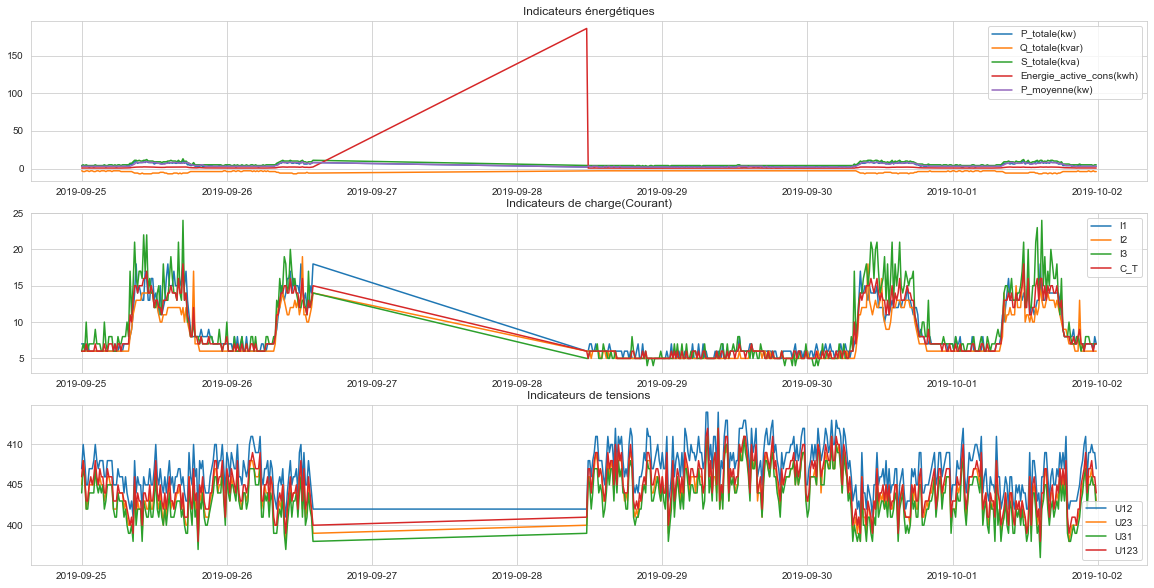

In [0]:
zoom=df.loc["2019-09-25":"2019-10-01"] 

ax=plt.subplot(3,1,1)
plt.plot(zoom[energy])
plt.legend(labels=energy)
plt.title('Indicateurs énergétiques')
ax=plt.subplot(3,1,2,sharex=ax)
plt.plot(zoom[currents])
plt.legend(labels=currents)
plt.title('Indicateurs de charge(Courant)')
plt.subplot(3,1,3,sharex=ax)
plt.plot(zoom[voltages]);
plt.legend(labels=voltages)
plt.title('Indicateurs de tensions');

>**On remarque que vers la fin du mois 9, les valeurs sont devenues distordues, pour le moment je vais éliminer tous les points à partir de cette période pour ne pas avoir des troues temporelles.** <br>
>**On peut aussi remarquer que `P_moyennes` est presque nulle par tout.**

In [0]:
df.drop(['P_moyenne(kw)'],inplace=True,axis=1)
df=df.loc[:'2019-09-26']# les valeurs distordues
df=df.iloc[1:]# la premiers valeurs de Energies_cons est NA

***A cause d l'existence des sauts dans les mesures la frequences d'echatillonage originale de 15min ne semble pas valide, je vais la rendre 30min en prennant la moyenne sur tous les deux points***

In [0]:
def add_freq(idx, freq=None):
    """Add a frequency attribute to idx, through inference or directly.

    Returns a copy.  If `freq` is None, it is inferred.
    """

    idx = idx.copy()
    if freq is None:
        if idx.freq is None:
            freq = pd.infer_freq(idx)
        else:
            return idx
    idx.freq = pd.tseries.frequencies.to_offset(freq)
    if idx.freq is None:
        raise AttributeError('no discernible frequency found to `idx`.  Specify'
                             ' a frequency string with `freq`.')
    return idx

In [0]:
resampled=df.resample(rule='30T').mean()
resampled.index=add_freq(resampled.index)

In [0]:
resampled.index

DatetimeIndex(['2019-04-01 00:30:00', '2019-04-01 01:00:00',
               '2019-04-01 01:30:00', '2019-04-01 02:00:00',
               '2019-04-01 02:30:00', '2019-04-01 03:00:00',
               '2019-04-01 03:30:00', '2019-04-01 04:00:00',
               '2019-04-01 04:30:00', '2019-04-01 05:00:00',
               ...
               '2019-09-26 09:30:00', '2019-09-26 10:00:00',
               '2019-09-26 10:30:00', '2019-09-26 11:00:00',
               '2019-09-26 11:30:00', '2019-09-26 12:00:00',
               '2019-09-26 12:30:00', '2019-09-26 13:00:00',
               '2019-09-26 13:30:00', '2019-09-26 14:00:00'],
              dtype='datetime64[ns]', name='TimeStamp', length=8572, freq='30T')

In [0]:
resampled.columns

Index(['I1', 'I2', 'I3', 'C_T', 'U12', 'U23', 'U31', 'U123', 'P_totale(kw)',
       'Q_totale(kvar)', 'S_totale(kva)', 'Energie_active_cons(kwh)'],
      dtype='object')

## Aperçu sur chaque indicateurs

In [0]:
vis_window=resampled.loc['2019-07-01':'2019-07-3'] # 3 jours

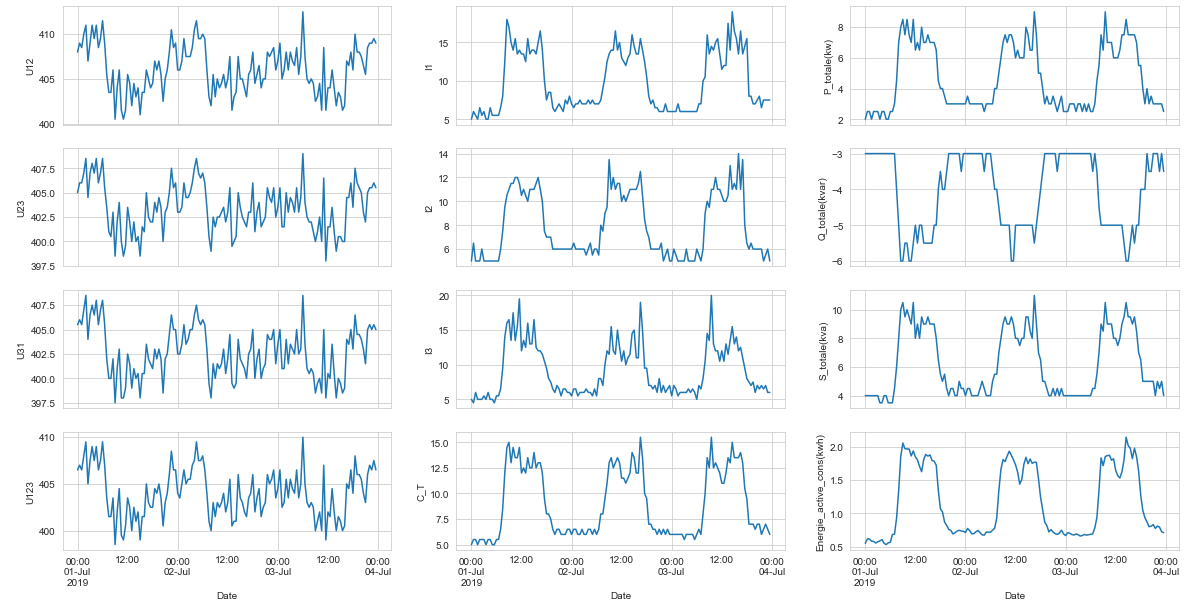

In [0]:
ax=plt.subplot(4,3,1)
vis_window[voltages[0]].plot();
plt.ylabel(voltages[0])
ax=plt.subplot(4,3,2,sharex=ax)
vis_window[currents[0]].plot();
plt.ylabel(currents[0])
plt.subplot(4,3,3,sharex=ax)
vis_window[energy[0]].plot();
plt.ylabel(energy[0])

ax=plt.subplot(4,3,4)
vis_window[voltages[1]].plot();
plt.ylabel('\n'+voltages[1])
ax=plt.subplot(4,3,5,sharex=ax)
vis_window[currents[1]].plot();
plt.ylabel('\n'+currents[1])
plt.subplot(4,3,6,sharex=ax)
vis_window[energy[1]].plot();
plt.ylabel('\n'+energy[1])

ax=plt.subplot(4,3,7)
vis_window[voltages[2]].plot();
plt.ylabel('\n'+voltages[2])
ax=plt.subplot(4,3,8,sharex=ax)
vis_window[currents[2]].plot();
plt.ylabel('\n'+currents[2])
plt.subplot(4,3,9,sharex=ax)
vis_window[energy[2]].plot();
plt.ylabel('\n'+energy[2])

ax=plt.subplot(4,3,10)
vis_window[voltages[3]].plot();
plt.ylabel('\n'+voltages[3])
plt.xlabel('Date');
ax=plt.subplot(4,3,11,sharex=ax)
vis_window[currents[3]].plot();
plt.ylabel('\n'+currents[3])
plt.xlabel('Date');
plt.subplot(4,3,12,sharex=ax)
vis_window[energy[3]].plot();
plt.ylabel('\n'+energy[3]);
plt.xlabel('Date');

# Décomposition Error, Trend, Seasonality (ETS) 

Une décomposition ETS suppose que la serie temporelle est une somme ou produit de trois elements:
>* **Trend:** La tendance générale de la série.<br>
* **Seasonality:** Une composante de saisonnalité qui fluctue avec une période spécifiée par l’analyste, Dans ne notre cas je travaille dans l’hypothèse d’une saisonnalité hebdomadaire.
* **Error:** le résiduel de la série originale est les  deux composantes précédentes, une composante Error petite signifie que nous avons bien décrit la série avec ces deux composantes. 

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
resampled.dropna(inplace=True)
periode=48*7 #(48 points par jours)

**Energie Active Consommée**

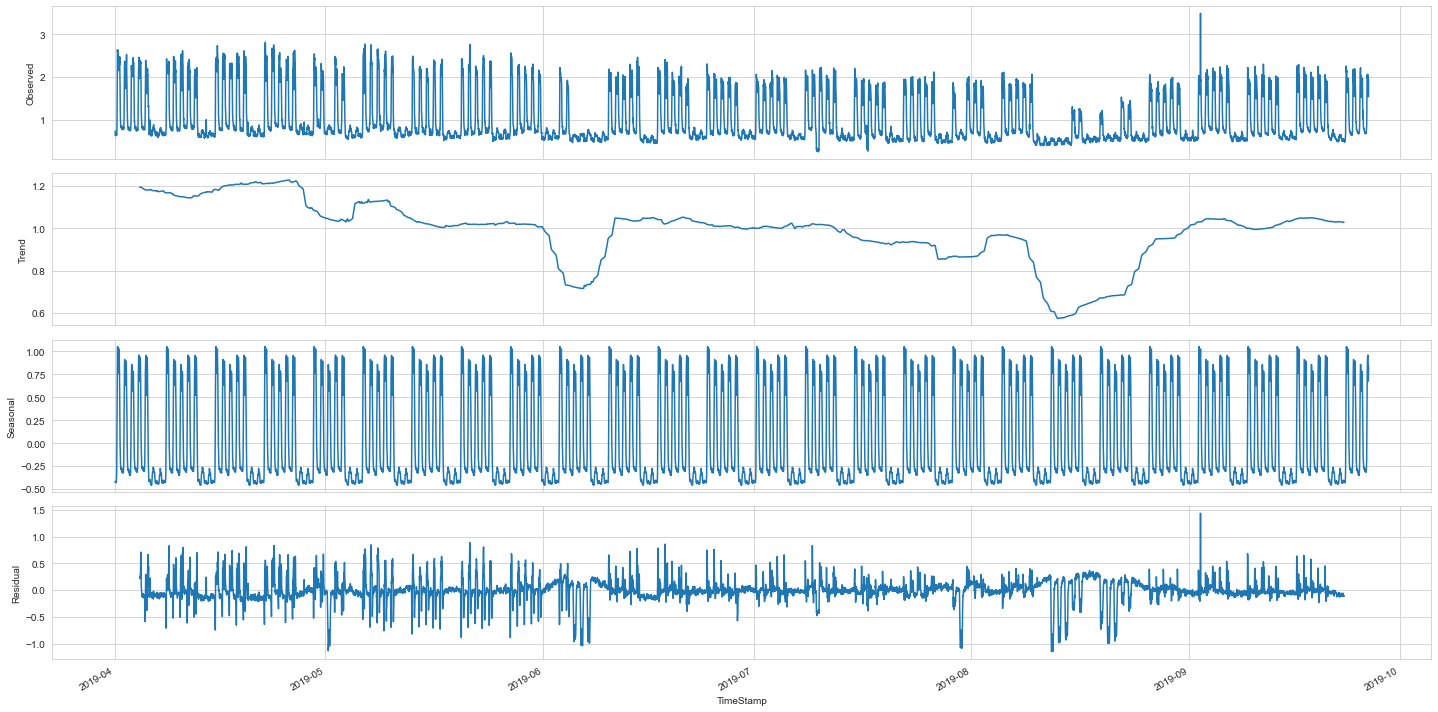

In [0]:
results=seasonal_decompose(resampled[energy[3]],freq=periode,model='add')# supposons le modele est additive y=s+e+t
results.plot();

**Puissance Apparente *S***

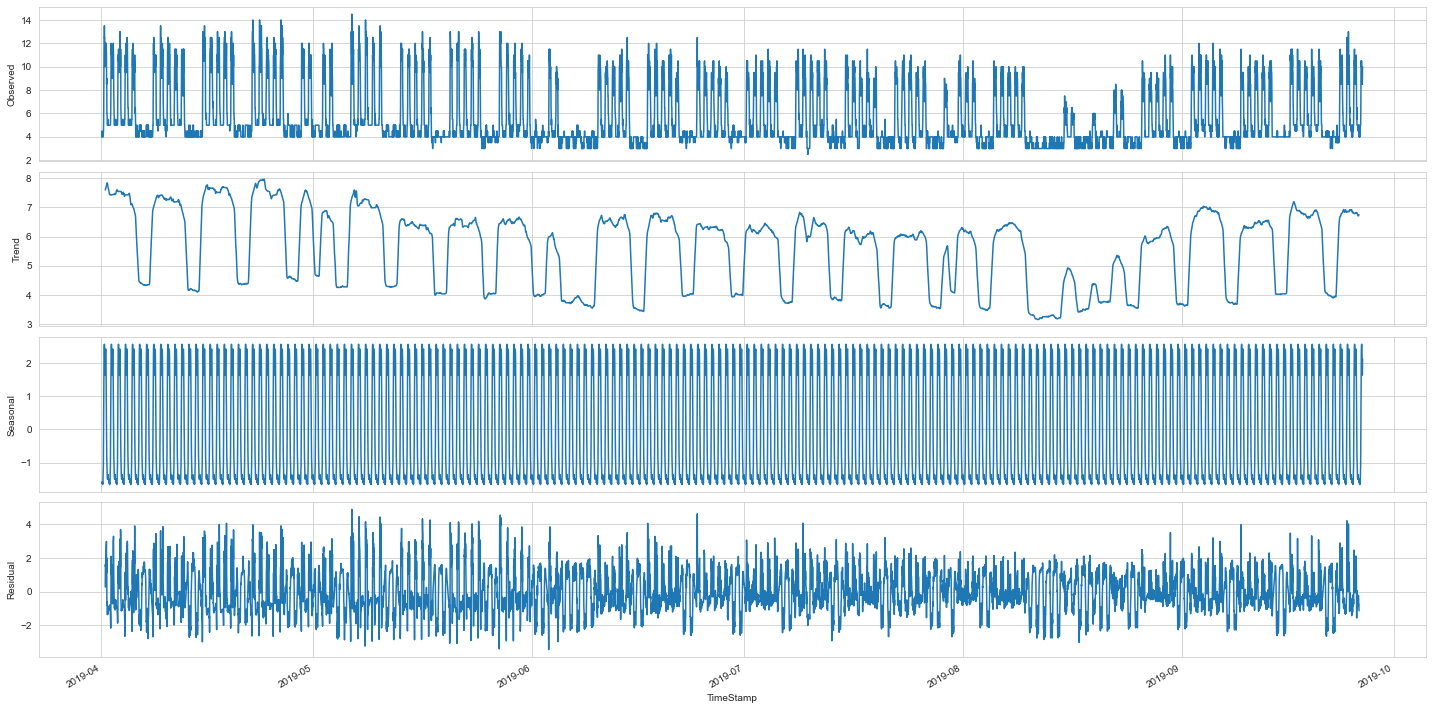

In [0]:
results=seasonal_decompose(resampled[energy[2]],freq=48,model='add')# supposons le modele est additive y=s+e+t
results.plot();

**Interprétation :**
>L’hypothèse de saisonnalité d’une semaine semble réaliste, mais avec un rapport d’erreur important. Ceci est due principalement à la présence d’un nombre d’anomalies(valeurs aberrantes) dans la série, qui peuvent faire l’objet d’un exercice d’anomaly detection, que j’adresserai dans une deuxième itération de ce travail.


# Prédiction 

In [0]:
len(resampled)

8569

**Séparation des données entre Training et testing.**

In [0]:
test_size=1500
test_set=resampled.iloc[-test_size:].copy()
train_set=resampled.iloc[:-test_size].copy()
print(f'pourcentage de test: {round(len(test_set)/len(resampled)*100)}%')

pourcentage de test: 18%


# Approche statistique :

## 2. Holtz-Winter

In [0]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train_set['TES_cons'] = ExponentialSmoothing(train_set[energy[3]],
                                             trend='add',
                                             seasonal_periods=48*7).fit().fittedvalues.shift(-1)

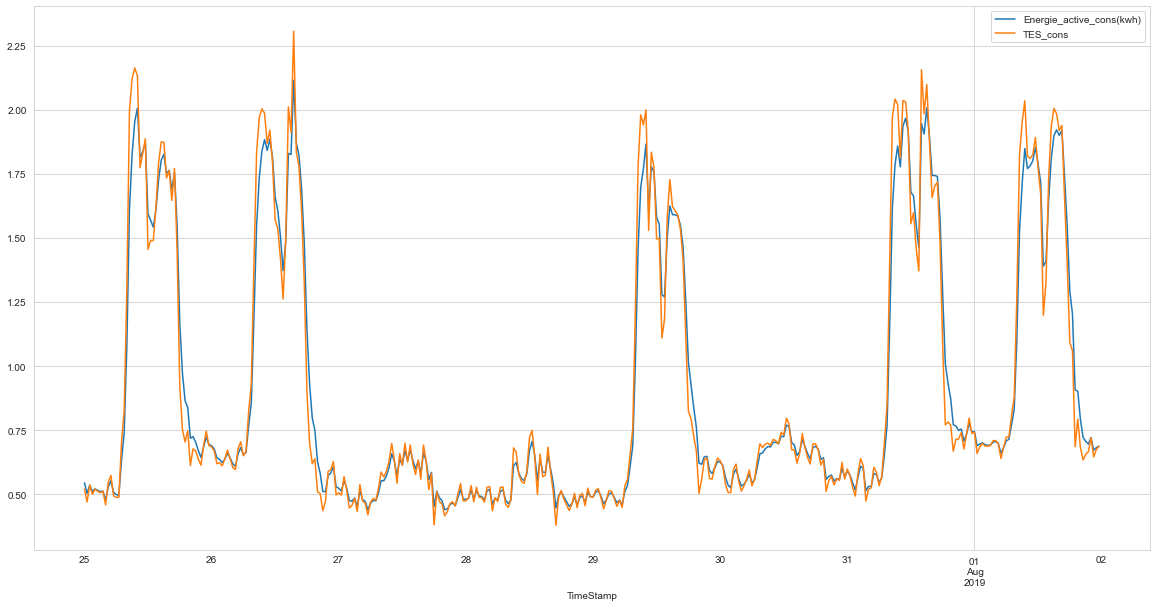

In [0]:
train_set[[energy[3],'TES_cons']].loc["2019-07-25":"2019-08-01"].plot();